<a href="https://colab.research.google.com/github/choprahetarth/computer-vision-experiments/blob/main/Revision_for_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/Traffic-Light/archive.zip -d /content/image

In [62]:
import os 
import pandas as pd
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow

## Read Dataset

In [11]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [52]:
list_of_xml_files = filelist('/content/image', 'xml')
anno_list = []
for i in list_of_xml_files:
  anno = {}
  root = ET.parse(i).getroot()
  anno['filename'] = '/content/image/images/'+root.find("./filename").text
  anno['width'] = root.find("./size/width").text
  anno['height'] = root.find("./size/height").text
  anno['class'] = root.find("./object/name").text
  anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
  anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
  anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
  anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
  anno_list.append(anno)
dataset = pd.DataFrame(anno_list)

In [53]:
dataset

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/image/images/road530.png,300,400,speedlimit,80,172,93,185
1,/content/image/images/road779.png,300,400,speedlimit,68,142,195,269
2,/content/image/images/road503.png,300,400,speedlimit,107,196,145,236
3,/content/image/images/road740.png,300,400,speedlimit,114,118,173,176
4,/content/image/images/road324.png,300,400,crosswalk,145,206,214,274
...,...,...,...,...,...,...,...,...
872,/content/image/images/road480.png,300,400,speedlimit,86,34,222,168
873,/content/image/images/road250.png,300,400,speedlimit,138,234,157,253
874,/content/image/images/road679.png,300,400,speedlimit,135,178,176,222
875,/content/image/images/road487.png,300,400,speedlimit,156,154,189,186


In [54]:
#label encode target
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
dataset['class'] = dataset['class'].apply(lambda x:  class_dict[x])

In [55]:
dataset

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/image/images/road530.png,300,400,0,80,172,93,185
1,/content/image/images/road779.png,300,400,0,68,142,195,269
2,/content/image/images/road503.png,300,400,0,107,196,145,236
3,/content/image/images/road740.png,300,400,0,114,118,173,176
4,/content/image/images/road324.png,300,400,2,145,206,214,274
...,...,...,...,...,...,...,...,...
872,/content/image/images/road480.png,300,400,0,86,34,222,168
873,/content/image/images/road250.png,300,400,0,138,234,157,253
874,/content/image/images/road679.png,300,400,0,135,178,176,222
875,/content/image/images/road487.png,300,400,0,156,154,189,186


## Handle Images

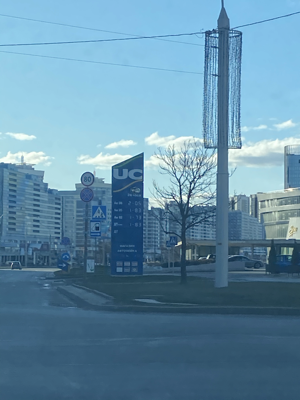

In [60]:
test_image = str(dataset['filename'][0])
im = cv2.imread(test_image)
cv2_imshow(im)

In [61]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [ ]:
# Basically create a mask for the image 
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image."""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


In [ ]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path) # READ THE IMAGE
    im_resized = cv2.resize(im, (int(1.49*sz), sz)) # RESIZE THE IMAGE
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz)) # RESIZE THE MASK 
    new_path = str(write_path/read_path.parts[-1]) 
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)